# Bibliotecas e funções auxiliares

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pandas as pd
import re

from itertools import pairwise
from urllib.parse import urlparse

In [15]:
DEFAULT_BINS = [0,1,2,5,10]

In [16]:
def clean_models(models: list):
    stop_words = ['+',  '120hz', '2', '4g', '5g', 'amarelo', 'azul',
                  'basic', 'bluetooth', 'br', 'branco', 'cinza', 'de',
                  'earbuds', 'earphone', 'earphones', 'escuro', 'fone',
                  'gradiente', 'inteligente', 'laranja', 'mi', 'prata',
                  'preto', 'pulseira', 'rosa', 'roxo', 'tela', 'true',
                  'verde', 'wireless', 'wireless']

    pattern = '(([\d]+gb)?[\d]+gb)|(\([\d\w-]+\))|(\d+,\d+)|([+"\/\',’])'
    models = [model.lower() for model in models]
    models = [re.sub(pattern,'',model) for model in models]
    models = list(set([' '.join([token for token in model.split() if token not in stop_words]) for model in models]))
    
    return models

In [17]:
def extract_site(url):
    if url:
        parsed_url = urlparse(url).netloc
        for prefix in ['www.', 'empresas.', 'm.', 'produto.', 'lista.', 'sp.']:
            if parsed_url.startswith(prefix):
                return parsed_url[len(prefix):]
        return parsed_url
    else:
        return '-'

In [76]:
def plot_results_count(df,bins=DEFAULT_BINS):
    
    search_results_count = df_search_results_ean[['original_query','results']].groupby('original_query').sum().values.reshape(-1,)
    heights,_ = np.histogram(search_results_count,bins=bins)
    x_labels = ['[{}-{})'.format(start,stop) for start,stop in pairwise(bins)]
    x_labels[-1] = x_labels[-1].replace(')',']')
    
    bar_colors = ['tab:blue'] * len(heights)
    bar_colors[0] = 'tab:red'
    bar_colors[heights.argmax()] = 'tab:orange'
    
    fig, ax = plt.subplots()
    
    for i in range(len(heights)):
        p = ax.bar(x_labels[i],heights[i], color=bar_colors[i], alpha=0.85)
        ax.bar_label(p, label_type='center')
    
    # remove all the ticks (both axes), and tick labels on the Y axis
    ax.tick_params(bottom=False, left=False,
                   labelbottom=True, labelleft=False)
    
    # remove the frame of the chart
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_ylabel('Quantidade por Faixa')
    ax.set_xlabel('Faixa de Resultados')
    ax.set_title('Quantidade de Resultados Obtidos')
    
    plt.show()


In [ ]:
def plot_top_sites(df,n_top=10):
    df_top_sites = df[['netloc','results']].groupby('netloc').sum().sort_values(by='results',ascending=False).head(n_top)
    top_sites = df_top_sites.index.values
    top_sites_count = df_top_sites.results.values
    
    top_sites_percentage = top_sites_count/top_sites_count.sum()
    top_sites_cum_percentage = top_sites_percentage.cumsum()
    bar_colors = ['tab:blue'] * n_top
    top_50_end = np.where(top_sites_cum_percentage>=0.5)[0][1]
    bottom_10 = np.where(top_sites_percentage<0.05)[0]
    for i in range(top_50_end):
        bar_colors[i] = 'tab:green'
    for i in bottom_10:
        bar_colors[i] = 'tab:red'
    
    y_pos = np.arange(len(top_sites))
    
    fig, ax = plt.subplots()
    
    for i in range(n_top):
        p = ax.barh(y_pos[i], top_sites_count[i], color = bar_colors[i], align='center', alpha=0.85)
        ax.bar_label(p,label_type='center')
        
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_yticks(y_pos, labels=top_sites)
    ax.set_title(f'Top {n_top} sites com mais resultados')
       
    # remove all the ticks (both axes), and tick labels on the Y axis
    ax.tick_params(bottom=False, left=False,
                   labelbottom=False, labelleft=True)
        
    # remove the frame of the chart
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
        
    plt.show()

# Carga e preparação dos dados

## Importação dos arquivos

In [19]:
# importar tabela completa do SCH (Dados Abertos)
file_sch = 'datasets/produtos_certificados.zip'
usecols = [0, 1, 2, 3, 11, 12, 13, 14, 15]
dtype = {'Número de Homologação': 'str',
         'CNPJ do Solicitante': 'str'}
df_sch = pd.read_csv(file_sch,sep=';',usecols=usecols,dtype=dtype)

# contar quantidade de números de homologação
df_sch['Quantidade de Número de Homologação']=df_sch[['Número de Homologação','Modelo']].groupby('Número de Homologação').transform('count')
df_sch = df_sch.sort_values(by=['Quantidade de Número de Homologação','Data da Homologação'],ascending=False).reset_index(drop=True)
df_sch.head()

,Data da Homologação,Número de Homologação,Nome do Solicitante,CNPJ do Solicitante,Nome do Fabricante,Modelo,Nome Comercial,Categoria do Produto,Tipo do Produto,Quantidade de Número de Homologação
0,26/12/2023,037242214637,Costa Verde Importação e Exportação EIRELI,36489846000184,"Shenzhen Jinhongxing Technology Co., Ltd.",W34+,Smartwatch,2,Equipamento de Radiocomunicação de Radiação Re...,319
1,26/12/2023,037242214637,Costa Verde Importação e Exportação EIRELI,36489846000184,"Shenzhen Jinhongxing Technology Co., Ltd.",W34+,Relógio Inteligente,2,Equipamento de Radiocomunicação de Radiação Re...,319
2,26/12/2023,037242214637,Costa Verde Importação e Exportação EIRELI,36489846000184,"Shenzhen Jinhongxing Technology Co., Ltd.",HW18,Smartwatch,2,Equipamento de Radiocomunicação de Radiação Re...,319
3,26/12/2023,037242214637,Costa Verde Importação e Exportação EIRELI,36489846000184,"Shenzhen Jinhongxing Technology Co., Ltd.",HW18,Relógio Inteligente,2,Equipamento de Radiocomunicação de Radiação Re...,319
4,26/12/2023,037242214637,Costa Verde Importação e Exportação EIRELI,36489846000184,"Shenzhen Jinhongxing Technology Co., Ltd.",HW19,Smartwatch,2,Equipamento de Radiocomunicação de Radiação Re...,319


In [20]:
# importar subset do SCH
file_subset_sch = 'datasets/subset_sch.txt'
dtype = {'Número de Homologação': 'str'}
df_subset_sch = pd.read_csv(file_subset_sch,names=['Número de Homologação'],dtype=dtype)

# merge SCH subset and SCH to join columns "Modelo" and "Nome Comercial"
columns_to_merge = ['Número de Homologação', 'Modelo', 'Nome Comercial']
df_subset_sch=df_subset_sch.merge(df_sch[columns_to_merge])
df_subset_sch = df_subset_sch.fillna('#NULO#')
df_subset_sch = df_subset_sch.drop_duplicates()
df_subset_sch.head()

,Número de Homologação,Modelo,Nome Comercial
0,037242214637,W34+,Smartwatch
1,037242214637,W34+,Relógio Inteligente
2,037242214637,HW18,Smartwatch
3,037242214637,HW18,Relógio Inteligente
4,037242214637,HW19,Smartwatch


In [21]:
# importa lista de EAN da Xiaomi
file_ean_xiaomi = 'datasets/ean_xiaomi.xlsx'
dtype = {'EAN': 'str'}
df_ean_xiaomi = pd.read_excel(file_ean_xiaomi,dtype=dtype)
df_ean_xiaomi.head()

,Código. Referencia,Descrição,EAN
0,CX298VRD,"Smartphone Xiaomi Redmi 9A Tela 6,53"" 2GB/32GB...",7898567779018
1,CX298AZU,"Smartphone Xiaomi Redmi 9A Tela 6,53"" 2GB/32GB...",7898567778998
2,CX298CIN,"Smartphone Xiaomi Redmi 9A Tela 6,53"" 2GB/32GB...",7898567779001
3,CX297VRD,"Smartphone Xiaomi Redmi 9 Tela 6,53"" 4GB/64GB ...",7898567778875
4,CX297ROX,"Smartphone Xiaomi Redmi 9 Tela 6,53"" 4GB/64GB ...",7898567778868


In [22]:
ean_to_search = df_ean_xiaomi['EAN']
ean_to_search.name='original_query'

ean_models_to_search = pd.Series(clean_models(df_ean_xiaomi['Descrição']))
ean_models_to_search.name='original_query'

sch_to_search = df_subset_sch['Número de Homologação'].drop_duplicates()
sch_to_search.name='original_query'

sch_models_to_search = pd.Series(list(set(df_subset_sch['Modelo'].unique().tolist()+df_subset_sch['Nome Comercial'].unique().tolist())))
sch_models_to_search.name='original_query'

In [23]:
# carregar resultados de pesquisa
file_search_results = 'datasets/search_results/products_search_results.parquet'
df_search_results = pd.read_parquet(file_search_results)

# dividir resultados de pesquisa em grupos de pesquisa
file_search_results_ean = 'datasets/search_results/products_search_results_ean.parquet'
file_search_results_ean_models = 'datasets/search_results/products_search_results_ean_models.parquet'
file_search_results_sch = 'datasets/search_results/products_search_results_sch.parquet'
file_search_results_sch_models = 'datasets/search_results/products_search_results_sch_models.parquet'

# carregar os arquivos por grupo, se já tiverem sido separados anteriormente,
# caso contrário, separar e salvar o arquivo correspondente
if osp.exists(file_search_results_ean):
    df_search_results_ean = pd.read_parquet(file_search_results_ean)    
    print(f'File {file_search_results_ean} loaded')
else:
    df_search_results_ean = df_search_results.merge(ean_to_search)
    df_search_results_ean.to_parquet(file_search_results_ean)
    print(f'Dataframe df_search_results_sch created and saved to file {file_search_results_ean}')

if osp.exists(file_search_results_ean_models):
    df_search_results_ean_models = pd.read_parquet(file_search_results_ean_models)  
    print(f'File {file_search_results_ean_models} loaded')
else:
    df_search_results_ean_models = df_search_results.merge(ean_models_to_search)
    df_search_results_ean_models.to_parquet(file_search_results_ean_models)
    print(f'Dataframe df_search_results_sch created and saved to file {file_search_results_ean_models}')

if osp.exists(file_search_results_sch):
    df_search_results_sch = pd.read_parquet(file_search_results_sch)   
    print(f'File {file_search_results_sch} loaded')
else:
    df_search_results_sch = df_search_results.merge(sch_to_search)
    df_search_results_sch.to_parquet(file_search_results_sch)
    print(f'Dataframe df_search_results_sch created and saved to file {file_search_results_sch}')

if osp.exists(file_search_results_sch_models):
    df_search_results_sch_models = pd.read_parquet(file_search_results_sch_models)   
    print(f'File {file_search_results_sch_models} loaded')
else:
    df_search_results_sch_models = df_search_results.merge(sch_models_to_search)
    df_search_results_sch_models.to_parquet(file_search_results_sch_models)
    print(f'Dataframe df_search_results_sch created and saved to file {file_search_results_sch_models}')

File datasets/search_results/products_search_results_ean.parquet loaded
File datasets/search_results/products_search_results_ean_models.parquet loaded
File datasets/search_results/products_search_results_sch.parquet loaded
File datasets/search_results/products_search_results_sch_models.parquet loaded


# Análise

In [24]:
df_search_results_ean['results'] = df_search_results_ean['url'].apply(lambda x: 0 if x is None else 1)
df_search_results_ean['netloc'] = df_search_results_ean['netloc'] = df_search_results_ean['url'].map(extract_site)
df_search_results_ean

,search_provider,original_query,name,url,snippet,results,netloc
0,Google,7898567779018,Smartphone Xiaomi Redmi 9A Tela 6.53 32GB 13MP...,https://www.amazon.com.br/Smartphone-Xiaomi-Re...,"‎7898567779018. Dimensões do produto, ‎17,3 x ...",1,amazon.com.br
1,Google,7898567779018,Smartphone Xiaomi Redmi 9A 32GB 4G Wi-Fi Tela ...,https://www.americanas.com.br/produto/47020707...,"7898567779018. Fabricante, DL Com. Ind. Prod. ...",1,americanas.com.br
2,Google,7898567779018,Redmi,https://www.hladicell.com.br/produtos/smartpho...,Descrição do Produto GTIN/EAN: 7898567779018 S...,1,hladicell.com.br
3,Google,7898567779018,Smartphone Xiaomi Redmi 9A 32GB Android 10 RAM...,https://www.lojasedmil.com.br/smartphone-xiaom...,Smartphone Xiaomi Redmi 9A 32GB Android 10 RAM...,1,lojasedmil.com.br
4,Google,7898567779018,Smartphone Xiaomi Redmi 9A ... - M&E Store ata...,https://www.mestoreatacado.com.br/smartphonexi...,GTIN/EAN: 7898567779018 Smartphone Xiaomi Redm...,1,mestoreatacado.com.br
...,...,...,...,...,...,...,...
545,Google,7908426308294,Smartphone Xiaomi Redmi Note 12 128GB Tela 6.6...,https://www.lojasnossolar.com.br/shopexd.asp?i...,"7908426308294. Linha, Redmi Note. Modelo, Note...",1,lojasnossolar.com.br
546,Google,7908426308300,Smartphone Xiaomi Redmi Note 12 128GB Verde Te...,https://www.bemol.com.br/smartphone-xiaomi-red...,EAN:7908426308300. Aviso:Imagens meramente ilu...,1,bemol.com.br
547,Google,7908426308942,None,None,None,0,-
548,Google,7908426308959,Smartphone Xiaomi Poco M4 5G 128GB Azul Tela 6...,https://www.bemol.com.br/smartphone-xiaomi-poc...,EAN:7908426308959. Aviso:Imagens meramente ilu...,1,bemol.com.br


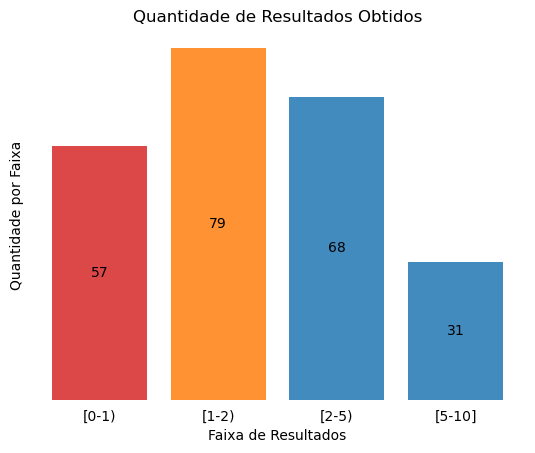

In [77]:
plot_results_count(df_search_results_ean)

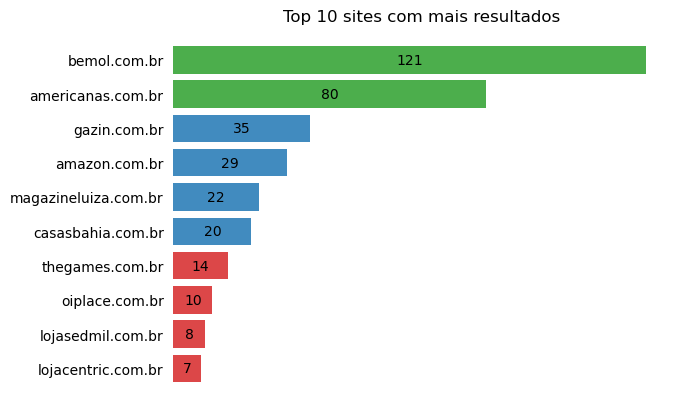

In [99]:
plot_top_sites(df_search_results_ean)

In [31]:
ax

array([<Axes: >, <Axes: >], dtype=object)